<a href="https://colab.research.google.com/github/Tclack88/MountainProject/blob/master/rp_os_pyramids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redpoint/Onsight ladders

In [0]:
import pandas as pd
import numpy as np
from math import floor
from datetime import datetime as dt
import seaborn as sb
import matplotlib.pyplot as plt
sb.set(style='whitegrid')

In [0]:
# Get Grade for conversion (from Mountain Project's official grade converter)
grade_chart = pd.read_html("https://www.mountainproject.com/international-climbing-grades")
old_ropes = grade_chart[0].YDSUSA[:-1].to_list()
new_ropes = [0,0,0,0,1,2,3,4,5,6,7,7.4,8,8.4,8.8,9,9.4,9.8]+list(np.round(np.arange(10,16,.1),1))
ropes_convert = dict(zip(old_ropes,new_ropes))

In [0]:
# Supporting functions for clean and prep pipeline
def clean_grade(grade):
  grade = str(grade).split()[0]
  if grade[0] == '5':
    grade = ropes_convert[grade]
    return grade

def x_round(x):
  """ rounds down to nearest .25
  eg. x_round(11.49) = 11.25, x_round(11.51) = 11.5
  """
  if x >= 10:
    return floor(x*4)/4
  else: return x

# trad_os.grade.apply(x_round).value_counts().sort_index(ascending=False)


# Rounding Key example:

# 10a, 10-, 10a/b  -> 10a
# 10b, 10          -> 10b
# 10b/c, 10c, 10+  -> 10c
# 10c/d, 10d       -> 10d


def grade_to_letter(grade):
  letter_map = {'.0':'a', '.25':'b', '.5':'c', '.75':'d'}
  letter_map_low = {'.0':'-', '.4':'', '.8':'+'}
  if grade >= 10:
    grade = str(grade)
    grade = grade[:2] + letter_map[grade[2:]]
    return grade
  else:
    grade = str(grade)
    grade = grade[:1] + letter_map_low[grade[1:]]
    return grade


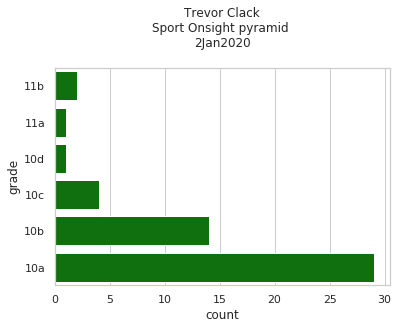

  grade  count
0   11b      2
1   11a      1
2   10d      1
3   10c      4
4   10b     14
5   10a     29


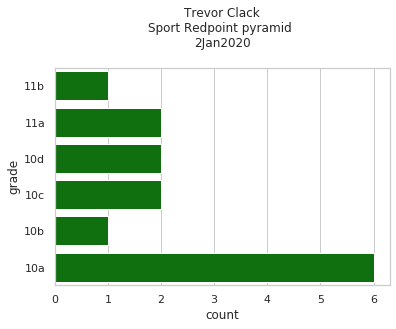

  grade  count
0   11b      1
1   11a      2
2   10d      2
3   10c      2
4   10b      1
5   10a      6


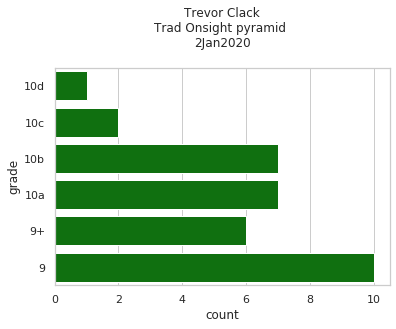

  grade  count
0   10d      1
1   10c      2
2   10b      7
3   10a      7
4    9+      6
5     9     10


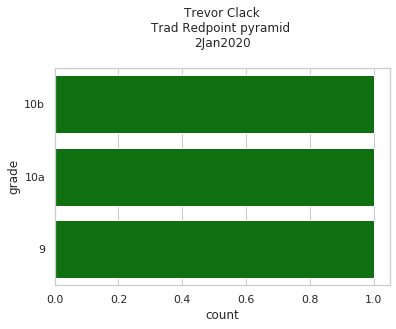

  grade  count
0   10b      1
1   10a      1
2     9      1


In [8]:
document = "https://www.mountainproject.com/user/109791883/trevor-clack/tick-export"
# document = "https://www.mountainproject.com/user/110296901/morgan-f/tick-export"
climber = document.split('/')[-2].replace('-',' ').title()
date = dt.now().strftime('%-d%b%Y')
data = pd.read_csv(document)
data = data[['Route', 'Rating', 'Style', 'Lead Style', 'Route Type']]
data = data.rename(columns = (dict(zip(data.columns,['route', 'grade', 'style', 'lead_style', 'type']))))
data.grade = data.grade.apply(clean_grade)
data = data[data['style'] == 'Lead']
# Split Trad and Sport data
trad = data[(data['type'] == 'Trad') | (data['type'] == 'Trad, Sport') | (data['type'] == 'Trad, Alpine') | (data['type'] == 'Trad, Aid')]
sport = data[(data['type'] == 'Sport') | (data['type'] == 'Sport, TR')]
trad_rp = trad[trad.lead_style == 'Redpoint']
trad_os = trad[trad.lead_style == 'Onsight']
trad_os.grade.apply(x_round).value_counts().sort_index(ascending=False)
sport_rp = sport[sport.lead_style == 'Redpoint']
sport_os = sport[sport.lead_style == 'Onsight']


styles = [sport_os, sport_rp, trad_os, trad_rp]

for style in styles:
  if not style.empty:
    title = f"{climber}\n{style.iloc[0]['type'].split(',')[0]} {style.iloc[0].lead_style} pyramid \n{date}\n"
    top_pyramid = style.grade.apply(x_round).value_counts().sort_index(ascending=False).iloc[:6].reset_index()
    top_pyramid.columns = ('grade','count')
    top_pyramid.grade = top_pyramid.grade.apply(grade_to_letter)
    sb.barplot(y='grade', x='count', data=top_pyramid, color='green')
    plt.title(title)
    plt.show()
    print(top_pyramid)

## Combined redpoint and os pyramid

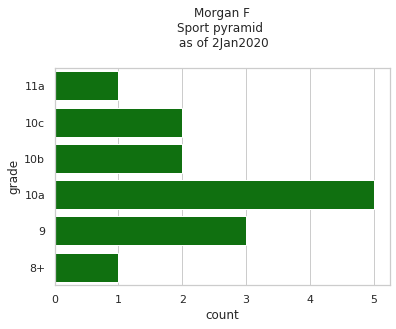

  grade  count
0   11a      1
1   10c      2
2   10b      2
3   10a      5
4     9      3
5    8+      1


		top 10
               route  grade style lead_style   type
3        Hole In One   11.0  Lead    Onsight  Sport
51        Lost Orbit   10.6  Lead    Onsight  Sport
68     One-Eyed Jack   10.6  Lead    Onsight  Sport
24  Ants Go Marching   10.3  Lead    Onsight  Sport
48            Hubble   10.3  Lead    Onsight  Sport
1    Little Red Book   10.0  Lead    Onsight  Sport
73   Change of Scene   10.0  Lead    Onsight  Sport
19       Holey Moley   10.0  Lead    Onsight  Sport
2          Easy Prey   10.0  Lead    Onsight  Sport
69         Easy Prey   10.0  Lead    Onsight  Sport


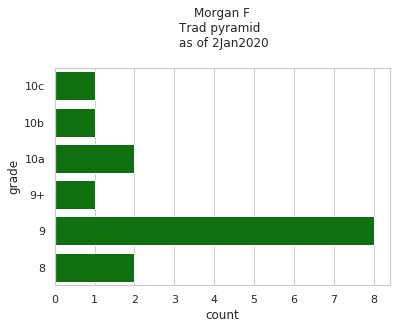

  grade  count
0   10c      1
1   10b      1
2   10a      2
3    9+      1
4     9      8
5     8      2


		top 10
                     route  grade style lead_style       type
29   The Squamish Buttress   10.6  Lead    Onsight       Trad
5           Stolen Chimney   10.4  Lead    Onsight  Trad, Aid
4    Dream of Wild Turkeys   10.0  Lead    Onsight       Trad
34          El Camino Real   10.0  Lead    Onsight       Trad
55          Igor Unchained    9.8  Lead    Onsight       Trad
31        St. Vitus' Dance    9.4  Lead    Onsight       Trad
36        Dave's Deviation    9.4  Lead    Onsight       Trad
42            Sexy Grandma    9.4  Lead    Onsight       Trad
28  The Squamish Butt Face    9.4  Lead    Onsight       Trad
60                Whodunit    9.4  Lead    Onsight       Trad


In [34]:
# document = "https://www.mountainproject.com/user/109791883/trevor-clack/tick-export"
document = "https://www.mountainproject.com/user/110296901/morgan-f/tick-export"
climber = document.split('/')[-2].replace('-',' ').title()
date = dt.now().strftime('%-d%b%Y')
data = pd.read_csv(document)
data = data[['Route', 'Rating', 'Style', 'Lead Style', 'Route Type']]
data = data.rename(columns = (dict(zip(data.columns,['route', 'grade', 'style', 'lead_style', 'type']))))
data.grade = data.grade.apply(clean_grade)
data = data[data['style'] == 'Lead']
# Split Trad and Sport data
trad = data[(data['type'] == 'Trad') | (data['type'] == 'Trad, Sport') | (data['type'] == 'Trad, Alpine') | (data['type'] == 'Trad, Aid')]
sport = data[(data['type'] == 'Sport') | (data['type'] == 'Sport, TR')]
trad_rp = trad[trad.lead_style == 'Redpoint']
trad_os = trad[trad.lead_style == 'Onsight']
trad_os.grade.apply(x_round).value_counts().sort_index(ascending=False)
sport_rp = sport[sport.lead_style == 'Redpoint']
sport_os = sport[sport.lead_style == 'Onsight']

sport_combined = pd.concat([sport_rp,sport_os], axis=0)
trad_combined = pd.concat([trad_rp, trad_os], axis=0)
styles = [sport_combined, trad_combined]

for style in styles:
  if not style.empty:
    title = f"{climber}\n{style.iloc[0]['type'].split(',')[0]} pyramid \n as of {date}\n"
    top_pyramid = style.grade.apply(x_round).value_counts().sort_index(ascending=False).iloc[:6].reset_index()
    top_pyramid.columns = ('grade','count')
    top_pyramid.grade = top_pyramid.grade.apply(grade_to_letter)
    sb.barplot(y='grade', x='count', data=top_pyramid, color='green')
    plt.title(title)
    plt.show()
    print(top_pyramid)
    print('\n\n\t\ttop 10')
    print(style.sort_values('grade',ascending=False).head(10))

In [22]:
trad_combined[trad_combined.grade >= 10]

,route,grade,style,lead_style,type
4,Dream of Wild Turkeys,10.0,Lead,Onsight,Trad
5,Stolen Chimney,10.4,Lead,Onsight,"Trad, Aid"
29,The Squamish Buttress,10.6,Lead,Onsight,Trad
34,El Camino Real,10.0,Lead,Onsight,Trad


In [0]:
sport_combined[sport[combined